In [2]:
import os
import pandas as pd
import numpy as np
from clearbox_engine import Dataset

/usr/local/lib/python3.9/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /usr/local/lib/python3.9/site-packages/clearbox_engine/metrics/privacy/gower_matrix_c.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
In file included from /usr/local/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /usr/local/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.pyxbld/temp.linux-x86_64-3.9/usr/local/lib/python3.9/site-packages/clearbox_engine/metrics/privacy/gower_matrix_c.c:1240:
/usr/local/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API 

In [3]:
#  Define license key
LICENSE_KEY = "licensekeyoverride2023@"

#  Load Original Dataset
file_path = "https://raw.githubusercontent.com/gillus/Corso_MLOps/refs/heads/main/data"

train_dataset = Dataset.from_csv(
    os.path.join(file_path, "adult_training.csv"),
    target_column="income",
    regression=False
)

In [3]:
def identify_discrepancies(df, target_column="income", positive_outcome=">50K"):

    sensitive_attributes = ["sex", "race", "marital_status", "age"]
    discrepancies = []

    for attr in sensitive_attributes:
        # Calculate positive outcome rate for each subgroup
        subgroup_counts = df.groupby(attr)[target_column].count()
        subgroup_positive_counts = df[df[target_column] == positive_outcome].groupby(attr)[target_column].count()
        positive_rate = (subgroup_positive_counts / subgroup_counts).fillna(0)

        # Calculate disparity from the average positive outcome rate
        avg_positive_rate = positive_rate.mean()
        disparity = positive_rate - avg_positive_rate

        # Append results
        for group, rate in positive_rate.items():
            discrepancies.append({
                "Attribute": attr,
                "Group": group,
                "Positive Rate": rate,
                "Disparity from Average": disparity[group]
            })

    # Convert to DataFrame for easier viewing
    discrepancy_df = pd.DataFrame(discrepancies)
    return discrepancy_df.sort_values(by="Disparity from Average")

In [4]:
# Convert the Dataset object to a DataFrame
train_df = pd.DataFrame(
    data=train_dataset.get_x(),
    columns=train_dataset.x_columns()
)

# Add the target column to the DataFrame
train_df["income"] = train_dataset.get_y()

# Now you can pass train_df to the identify_discrepancies function
discrepancy_summary = identify_discrepancies(train_df)

# Set display options to show the entire DataFrame
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Don't limit the display width
pd.set_option('display.max_colwidth', None)  # Don't truncate column content

# Print the full DataFrame
print(discrepancy_summary)


         Attribute               Group  Positive Rate  Disparity from Average
81             age                  88       0.000000               -0.234250
80             age                  86       0.000000               -0.234250
79             age                  85       0.000000               -0.234250
14             age                  20       0.000000               -0.234250
76             age                  82       0.000000               -0.234250
12             age                  18       0.000000               -0.234250
11             age                  17       0.000000               -0.234250
13             age                  19       0.001684               -0.232566
15             age                  21       0.004831               -0.229419
17             age                  23       0.014563               -0.219687
16             age                  22       0.017804               -0.216446
18             age                  24       0.039894           

 Masks for Synthetic Data Generation:
 
1️⃣ Female + Older Age (85+):
mask = (features_df["sex"] == "Female") & (features_df["age"] >= 85) & (labels_array == ">50K")

2️⃣ Female + Never-Married:
mask = (features_df["sex"] == "Female") & (features_df["marital_status"] == "Never-Married") & (labels_array == ">50K")

3️⃣ Black + Female:
mask = (features_df["race"] == "Black") & (features_df["sex"] == "Female") & (labels_array == ">50K")

4️⃣ Black + Never-Married:
mask = (features_df["race"] == "Black") & (features_df["marital_status"] == "Never-Married") & (labels_array == ">50K")


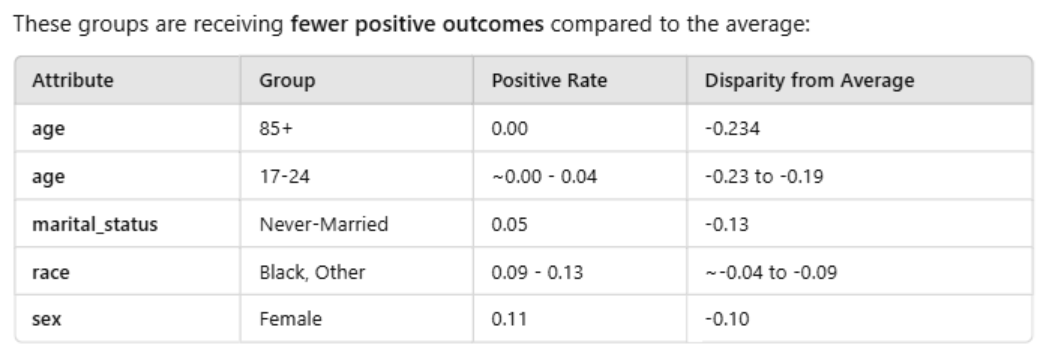

In [4]:
def identify_intersectional_discrepancies(df, target_column="income", positive_outcome=">50K"):
 
    # Define the intersectional attributes you want to analyze
    intersectional_attributes = [
        ("sex", "race"),
        ("sex", "marital_status"),
        ("race", "marital_status"),
        ("sex", "age")
    ]

    discrepancies = []

    for attrs in intersectional_attributes:
        # Create a combined attribute column for intersectional groups
        df["Intersectional Group"] = df.loc[:, list(attrs)].apply(lambda x: " + ".join(x.astype(str)), axis=1)

        # Calculate positive outcome rate for each intersectional group
        subgroup_counts = df.groupby("Intersectional Group")[target_column].count()
        subgroup_positive_counts = df[df[target_column] == positive_outcome].groupby("Intersectional Group")[target_column].count()
        positive_rate = (subgroup_positive_counts / subgroup_counts).fillna(0)

        # Calculate disparity from the average positive outcome rate
        avg_positive_rate = positive_rate.mean()
        disparity = positive_rate - avg_positive_rate

        # Append results
        for group, rate in positive_rate.items():
            discrepancies.append({
                "Intersectional Group": group,
                "Attributes": " + ".join(attrs),
                "Positive Rate": rate,
                "Disparity from Average": disparity[group]
            })

    # Convert to DataFrame for easier viewing
    discrepancy_df = pd.DataFrame(discrepancies)
    return discrepancy_df.sort_values(by="Disparity from Average")


In [5]:
# Convert the Dataset object to a DataFrame
train_df = pd.DataFrame(
    data=train_dataset.get_x(),
    columns=train_dataset.x_columns()
)

# Add the target column to the DataFrame
train_df["income"] = train_dataset.get_y()

# Run the intersectional discrepancy function
intersectional_discrepancy_summary = identify_intersectional_discrepancies(train_df)

# Set display options to show the entire DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Print the full intersectional discrepancy summary
print(intersectional_discrepancy_summary)


                   Intersectional Group             Attributes  Positive Rate  \
38                          Female + 17              sex + age       0.000000   
90                          Female + 69              sex + age       0.000000   
109                           Male + 17              sex + age       0.000000   
107                         Female + 88              sex + age       0.000000   
106                         Female + 86              sex + age       0.000000   
101                         Female + 80              sex + age       0.000000   
105                         Female + 85              sex + age       0.000000   
104                         Female + 84              sex + age       0.000000   
110                           Male + 18              sex + age       0.000000   
103                         Female + 82              sex + age       0.000000   
39                          Female + 18              sex + age       0.000000   
40                          

11               Female + Never-Married   sex + marital_status       0.037801   
2                        Female + Black             sex + race       0.060758  
0                           Female                  sex              0.113678   